# Effective amplitude spectrum calculation

In [36]:
import re

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import numba

%matplotlib inline

## Load time series

In [25]:
def load_at2(fname):
    with open(fname) as fp:
        # Skip 3 header lines
        for _ in range(3):
            next(fp)
        # Find count and timestep.
        # Ex: 'NPTS=   5093, DT=   .0100 SEC, '
        # Here a regular expression is used to find numbers in the line
        parts = re.findall(r'[.0-9]+', next(fp))
        count = int(parts[0])
        time_step = float(parts[1])
        accels = np.array([p for l in fp for p in l.split()]).astype(float)
        
    return {'time_step': time_step, 'accels': accels}

In [26]:
fnames = ['data/RSN763_LOMAP_GIL067.AT2', 'data/RSN763_LOMAP_GIL337.AT2']

time_series = [load_at2(fname) for fname in fnames]

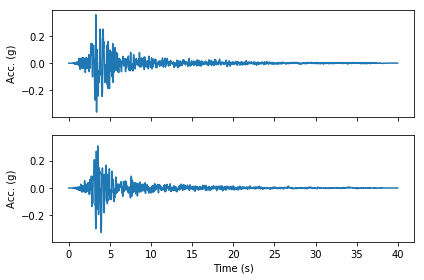

In [27]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)

for ax, ts in zip(axes, time_series):
    times = ts['time_step'] * np.arange(ts['accels'].size)
    ax.plot(times, ts['accels'])

plt.setp(axes, ylabel='Acc. (g)')
axes[-1].set(xlabel='Time (s)')

fig.tight_layout()

## Calculate Fourier spectra

In [28]:
assert len(time_series[0]) == len(time_series[1])

In [40]:
for ts in time_series:
    ts['fourier_amps'] = np.fft.rfft(ts['accels'])
    
ts0 = time_series[0]
freqs = np.fft.rfftfreq(ts0['accels'].size, d=ts0['time_step'])

effect_amps = np.sqrt(np.mean(
    [np.abs(ts['fourier_amps']) ** 2 for ts in time_series], axis=0))

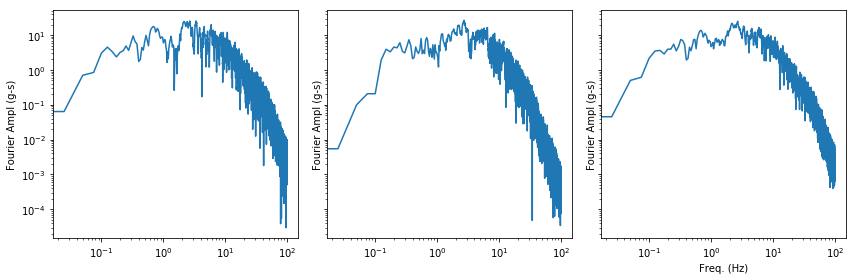

In [41]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))

for ts, ax in zip(time_series, axes):
    ax.plot(freqs, np.abs(ts['fourier_amps']))
    
axes[-1].plot(freqs, np.abs(effect_amps))

plt.setp(axes, ylabel='Fourier Ampl (g-s)', xscale='log', yscale='log')
axes[-1].set(xlabel='Freq. (Hz)')

fig.tight_layout()

## Smoothed spectrum

In [42]:
@numba.jit
def konno_omachi_smooth(freqs, amps, bandwidth, fc):
    # FIXME revisit this
    # Limiting calculation at 3 provides a window value of 4.9E-6 and speeds up
    # calculation
    max_ratio = 10 ** (3 / bandwidth)

    window_total = 0
    total = 0

    for i, freq in enumerate(freqs):
        if abs(freq - fc) < 1E-6:
            window = 1.
        elif (abs(freq - 0) < 1E-6) or (abs(fc - 0) < 1E-6):
            window = 0
        elif (freq / fc) > max_ratio or (fc / freq) > max_ratio:
            continue
        else:
            x = bandwidth * np.log10(freq / fc)
            window = (np.sin(x) / x) ** 4

        total += window * amps[i]
        window_total += window

    return total / window_total

In [43]:
ko_bandwidth = 30
freqs_interp = np.logspace(-1, 2, num=301)
smoothed = np.array([
    konno_omachi_smooth(freqs, effect_amps, ko_bandwidth, fc)
    for fc in freqs_interp
])

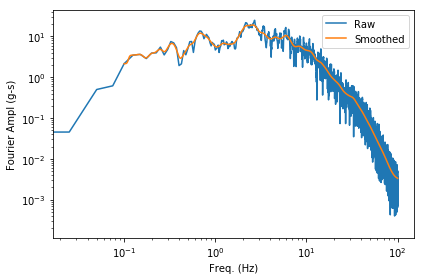

In [44]:
fig, ax = plt.subplots()

ax.plot(freqs, effect_amps, label='Raw')
ax.plot(freqs_interp, smoothed, label='Smoothed')

ax.set(
    xlabel='Freq. (Hz)', xscale='log',
    ylabel='Fourier Ampl (g-s)', yscale='log'
)
ax.legend()

fig.tight_layout()

In [45]:
df = pd.DataFrame.from_records(
    np.c_[freqs_interp, smoothed], 
    columns=['freq', 'effect_amp']
)
df

,freq,effect_amp
0,0.100000,2.152017
1,0.102329,2.153996
2,0.104713,2.169640
3,0.107152,2.241407
4,0.109648,2.467305
5,0.112202,2.887485
6,0.114815,3.262131
7,0.117490,3.429845
8,0.120226,3.477253
9,0.123027,3.486643


In [46]:
df.to_csv('data/RSN763_LOMAP_GIL-EAS.csv', index=False)